Pour une lecture améliorée, ce notebook est idéalement lu avec une extension qui gère les niveaux des titres Markdown.  
Par exemple avec l'extension 'Table of Contents' du module 'Nbextensions' de Jupyter.

# Mise en place du notebook

## Import des modules

In [362]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress as reg_lin
from mesfonctions import scatter_plot
from mesfonctions import arrondi
from mesfonctions import display_scores

from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.compose import TransformedTargetRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor

from graphviz import Source
from sklearn.tree import export_graphviz


In [363]:
# pour développement only - cellule à supprimer du notebook final
import mesfonctions
from importlib import reload  
mesfonctions = reload(mesfonctions)
# from mesfonctions import xxx

## Gestion des paramètres d'affichage de Jupyter

In [485]:
# pour gérer l'affichage des dataframes pandas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 200

# pour gérer l'affichage des arrays numpy
# 230 sur ma config bureau, 160 sur ma config portable
np.set_printoptions(linewidth=160)

# affichage des objets sklearn
set_config(display='diagram')

# pour afficher les gros fichiers sur toute la largeur de l'écran
from IPython.core.display import HTML
HTML("<style>.container { width:95% }</style>")

## Fonctions en cours de développement (à déplacer ultérieurement dans un fichier .py externe)

## Chargement du pickle du df nettoyé

In [365]:
df1 = pd.read_pickle('df1_après_nettoyage_Projet_Seattle.pkl')

# Première approche du problème : conservation d'un grand nombre de variables

## Feature engineering - première approche

### Surface au sol

Les pertes énergétiques des bâtiments avec une forte surface de contact avec l'extérieur seront plus importantes que celles des bâtiments avec une faible surface de contact.  
Sur la base des données disponibles, on ne pourra pas calculer cette surface.  
Toutefois on peut calculer la surface au sol des bâtiments. C'est un bon proxy de la surface de contact totale pour les bâtiments à peu d'étages.

Surface_au_sol(sf) = PropertyGFABuilding(s) / NumberofFloors 


In [366]:
df1['Surface_au_sol(sf)'] = df1['PropertyGFABuilding(s)'].copy() / df1['NumberofFloors'].copy()

In [367]:
df1['Surface_au_sol(sf)'].describe()

count    1.668000e+03
mean              inf
std               NaN
min      2.216970e+02
25%      1.235629e+04
50%      2.119500e+04
75%      3.438105e+04
max               inf
Name: Surface_au_sol(sf), dtype: float64

Il y a des valeurs np.inf lorsque NumberofFloors vaut 0 => on les transforme en NaN.

In [368]:
df1['Surface_au_sol(sf)'] = df1['Surface_au_sol(sf)'].apply(lambda x : np.NaN if x == np.inf else x)

In [369]:
df1['Surface_au_sol(sf)'].describe()

count    1.652000e+03
mean     3.177939e+04
std      4.708716e+04
min      2.216970e+02
25%      1.229850e+04
50%      2.102900e+04
75%      3.361888e+04
max      1.100000e+06
Name: Surface_au_sol(sf), dtype: float64

### Variables prédites

La demande de Douglas est de prédire les variables :  
    - 'SiteEnergyUse(kBtu)',  
    - 'TotalGHGEmissions',  
cependant, nous travaillerons plutôt sur la prévision de :  
    - 'SiteEUI(kBtu/sf)',  
    - 'GHGEmissionsIntensity',  
qui ont une relation plus "linéaire" avec les autres variables descriptives. 

## Variables retenues pour la modélisation

In [370]:
list(df1.columns)

['OSEBuildingID',
 'BuildingType',
 'PrimaryPropertyType',
 'ZipCode',
 'CouncilDistrictCode',
 'Neighborhood',
 'Latitude',
 'Longitude',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'LargestPropertyUseType',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseType',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseType',
 'ThirdLargestPropertyUseTypeGFA',
 'ENERGYSTARScore',
 'SiteEUI(kBtu/sf)',
 'SiteEUIWN(kBtu/sf)',
 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SiteEnergyUseWN(kBtu)',
 'SteamUse(kBtu)',
 'Electricity(kWh)',
 'Electricity(kBtu)',
 'NaturalGas(therms)',
 'NaturalGas(kBtu)',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 'Surface_au_sol(sf)']

La demande de Douglas est de prédire les variables :  
    - 'SiteEnergyUse(kBtu)',  
    - 'TotalGHGEmissions',  
cependant, nous travaillerons plutôt sur la prévision de :  
    - 'SiteEUI(kBtu/sf)',  
    - 'GHGEmissionsIntensity',  
qui ont un lien plus "linéaire" avec les autres variables descriptives. 

In [371]:
liste_variables_pour_modelisation =[
    'BuildingType', 
    'PrimaryPropertyType', 
    'ZipCode',
    'CouncilDistrictCode', 
    'Neighborhood', 
    'Latitude', 
    'Longitude',
    'YearBuilt', 
    'NumberofBuildings', 
    'NumberofFloors', 
#     'PropertyGFATotal',    exclu car donnée extensive
#     'PropertyGFAParking',    exclu car donnée extensive
#     'PropertyGFABuilding(s)',  exclu car donnée extensive
    'LargestPropertyUseType',
#     'LargestPropertyUseTypeGFA',  exclu car donnée extensive
    'SecondLargestPropertyUseType', 
#     'SecondLargestPropertyUseTypeGFA',  exclu car donnée extensive
    'ThirdLargestPropertyUseType', 
#     'ThirdLargestPropertyUseTypeGFA',  exclu car donnée extensive
#     'ENERGYSTARScore', exclu sinon data leak
#     'SiteEUI(kBtu/sf)', variable à prédire
#     'SiteEUIWN(kBtu/sf)', exclu sinon data leak
#     'SourceEUI(kBtu/sf)', exclu sinon data leak
#     'SourceEUIWN(kBtu/sf)', exclu sinon data leak
#     'SiteEnergyUse(kBtu)', exclu sinon data leak
#     'SiteEnergyUseWN(kBtu)', exclu sinon data leak
#     'SteamUse(kBtu)', exclu sinon data leak
#     'Electricity(kWh)',exclu sinon data leak
#     'Electricity(kBtu)', exclu sinon data leak
#     'NaturalGas(therms)', exclu sinon data leak
#     'NaturalGas(kBtu)',exclu sinon data leak
#     'TotalGHGEmissions', exclu sinon data leak
#     'GHGEmissionsIntensity', variable à prédire
    'Surface_au_sol(sf)']

## Train test split 

POUR LE NOTEBOOK FINAL IL FAUDRA FAIRE LE SPLIT PLUS TOT (avant le nettoyage)  
IL FAUDRA FAIRE LE MEME NETTOYAGE SUR LES JEUX TRAIN ET TEST

POUR L'INSTANT ON NE TRAVAILLE QU'A LA PREDICTION DE SiteEUI(kBtu/sf)

In [372]:
# Suppression des lignes pour lesquelles la variable 'SiteEUI(kBtu/sf)' n'est pas renseignée
df1 = df1.dropna(subset=['SiteEUI(kBtu/sf)']).copy()

##### Variable à prédire :

In [373]:
y1_EUI = df1[['SiteEUI(kBtu/sf)']].copy()
# y1_GHGEI = df1['GHGEmissionsIntensity'].copy()     Pour l'instant on se contente de prédire y1_EUI.

##### Variables explicatives :

In [374]:
X1 = df1[liste_variables_pour_modelisation].copy()

##### Split :

In [375]:
X_train_EUI, X_test_EUI, y_train_EUI, y_test_EUI = train_test_split(X1, y1_EUI, test_size=0.2, random_state=0)

## Imputations

### Définition des variables quantitatives et qualitatives

In [376]:
list(X_train_EUI.columns)

['BuildingType',
 'PrimaryPropertyType',
 'ZipCode',
 'CouncilDistrictCode',
 'Neighborhood',
 'Latitude',
 'Longitude',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'Surface_au_sol(sf)']

In [377]:
liste_variables_qualitatives = [
 'BuildingType',
 'PrimaryPropertyType',
 'ZipCode',
 'CouncilDistrictCode',
 'Neighborhood',
#  'Latitude',
#  'Longitude',
#  'YearBuilt',
#  'NumberofBuildings',
#  'NumberofFloors',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
#  'Surface_au_sol(sf)'
]

In [378]:
liste_variables_quantitatives = [
#  'BuildingType',
#  'PrimaryPropertyType',
#  'ZipCode',
#  'CouncilDistrictCode',
#  'Neighborhood',
 'Latitude',
 'Longitude',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
#  'LargestPropertyUseType',
#  'SecondLargestPropertyUseType',
#  'ThirdLargestPropertyUseType',
 'Surface_au_sol(sf)'
]

In [379]:
X_train_EUI

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,Surface_au_sol(sf)
3162,NonResidential,Large Office,98109.0,7,LAKE UNION,47.62037,-122.33627,2012,1.0,11,Office,Parking,Other,47856.636364
953,NonResidential,Worship Facility,98115.0,4,NORTHEAST,47.68752,-122.29852,2000,1.0,2,Worship Facility,NaN,NaN,15693.000000
2637,NonResidential,Hotel,98108.0,2,GREATER DUWAMISH,47.54774,-122.32091,1992,1.0,3,Hotel,NaN,NaN,7484.000000
29,NonResidential,Hotel,98121.0,7,DOWNTOWN,47.61558,-122.34186,1978,1.0,5,Hotel,NaN,NaN,10442.000000
1126,NonResidential,Small- and Mid-Sized Office,98108.0,2,GREATER DUWAMISH,47.55316,-122.32616,1982,1.0,2,Office,Non-Refrigerated Warehouse,NaN,20014.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,NonResidential,Retail Store,98134.0,2,GREATER DUWAMISH,47.56535,-122.34054,1953,1.0,1,Retail Store,Non-Refrigerated Warehouse,NaN,39900.000000
1192,NonResidential,Small- and Mid-Sized Office,98133.0,5,NORTHWEST,47.72004,-122.34418,1951,1.0,2,Office,Non-Refrigerated Warehouse,NaN,19907.500000
2120,NonResidential,Warehouse,98108.0,1,GREATER DUWAMISH,47.53160,-122.33300,1970,1.0,1,Non-Refrigerated Warehouse,NaN,NaN,44000.000000
580,NonResidential,University,98122.0,3,CENTRAL,47.60940,-122.31506,1916,1.0,2,College/University,Parking,NaN,30061.000000


In [380]:
X_train_EUI[liste_variables_quantitatives].describe()

,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,Surface_au_sol(sf)
count,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1.307000e+03
mean,47.616247,-122.332559,1962.246212,1.156818,4.200758,3.116310e+04
std,0.048964,0.024321,32.540533,3.187654,6.912526,4.779553e+04
min,47.510180,-122.411820,1900.000000,0.000000,0.000000,2.216970e+02
25%,47.584275,-122.342598,1930.000000,1.000000,1.000000,1.247250e+04
50%,47.612380,-122.332890,1966.000000,1.000000,2.000000,2.097500e+04
75%,47.650627,-122.321848,1989.000000,1.000000,4.000000,3.254500e+04
max,47.733870,-122.258640,2015.000000,111.000000,99.000000,1.100000e+06


In [381]:
X_train_EUI[liste_variables_quantitatives]

,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,Surface_au_sol(sf)
3162,47.62037,-122.33627,2012,1.0,11,47856.636364
953,47.68752,-122.29852,2000,1.0,2,15693.000000
2637,47.54774,-122.32091,1992,1.0,3,7484.000000
29,47.61558,-122.34186,1978,1.0,5,10442.000000
1126,47.55316,-122.32616,1982,1.0,2,20014.500000
...,...,...,...,...,...,...
1045,47.56535,-122.34054,1953,1.0,1,39900.000000
1192,47.72004,-122.34418,1951,1.0,2,19907.500000
2120,47.53160,-122.33300,1970,1.0,1,44000.000000
580,47.60940,-122.31506,1916,1.0,2,30061.000000


### Imputation des variables quantitatives

In [382]:
imputer_quanti = SimpleImputer(strategy="median")

In [383]:
X_train_EUI[liste_variables_quantitatives] = imputer_quanti.fit_transform(X_train_EUI[liste_variables_quantitatives])

<ipython-input-383-f1c96264e1c9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_EUI[liste_variables_quantitatives] = imputer_quanti.fit_transform(X_train_EUI[liste_variables_quantitatives])
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [384]:
X_train_EUI[liste_variables_quantitatives].describe()

,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,Surface_au_sol(sf)
count,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1.320000e+03
mean,47.616247,-122.332559,1962.246212,1.156818,4.200758,3.106277e+04
std,0.048964,0.024321,32.540533,3.187654,6.912526,4.757006e+04
min,47.510180,-122.411820,1900.000000,0.000000,0.000000,2.216970e+02
25%,47.584275,-122.342598,1930.000000,1.000000,1.000000,1.265917e+04
50%,47.612380,-122.332890,1966.000000,1.000000,2.000000,2.097500e+04
75%,47.650627,-122.321848,1989.000000,1.000000,4.000000,3.236550e+04
max,47.733870,-122.258640,2015.000000,111.000000,99.000000,1.100000e+06


In [385]:
imputer_quanti.statistics_

array([ 4.7612380e+01, -1.2233289e+02,  1.9660000e+03,  1.0000000e+00,  2.0000000e+00,  2.0975000e+04])

### Imputation des variables qualitatives

In [386]:
X_train_EUI

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,Surface_au_sol(sf)
3162,NonResidential,Large Office,98109.0,7,LAKE UNION,47.62037,-122.33627,2012.0,1.0,11.0,Office,Parking,Other,47856.636364
953,NonResidential,Worship Facility,98115.0,4,NORTHEAST,47.68752,-122.29852,2000.0,1.0,2.0,Worship Facility,NaN,NaN,15693.000000
2637,NonResidential,Hotel,98108.0,2,GREATER DUWAMISH,47.54774,-122.32091,1992.0,1.0,3.0,Hotel,NaN,NaN,7484.000000
29,NonResidential,Hotel,98121.0,7,DOWNTOWN,47.61558,-122.34186,1978.0,1.0,5.0,Hotel,NaN,NaN,10442.000000
1126,NonResidential,Small- and Mid-Sized Office,98108.0,2,GREATER DUWAMISH,47.55316,-122.32616,1982.0,1.0,2.0,Office,Non-Refrigerated Warehouse,NaN,20014.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,NonResidential,Retail Store,98134.0,2,GREATER DUWAMISH,47.56535,-122.34054,1953.0,1.0,1.0,Retail Store,Non-Refrigerated Warehouse,NaN,39900.000000
1192,NonResidential,Small- and Mid-Sized Office,98133.0,5,NORTHWEST,47.72004,-122.34418,1951.0,1.0,2.0,Office,Non-Refrigerated Warehouse,NaN,19907.500000
2120,NonResidential,Warehouse,98108.0,1,GREATER DUWAMISH,47.53160,-122.33300,1970.0,1.0,1.0,Non-Refrigerated Warehouse,NaN,NaN,44000.000000
580,NonResidential,University,98122.0,3,CENTRAL,47.60940,-122.31506,1916.0,1.0,2.0,College/University,Parking,NaN,30061.000000


In [387]:
X_train_EUI[liste_variables_qualitatives].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1320 entries, 3162 to 839
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   BuildingType                  1320 non-null   object 
 1   PrimaryPropertyType           1320 non-null   object 
 2   ZipCode                       1307 non-null   float64
 3   CouncilDistrictCode           1320 non-null   int64  
 4   Neighborhood                  1320 non-null   object 
 5   LargestPropertyUseType        1316 non-null   object 
 6   SecondLargestPropertyUseType  686 non-null    object 
 7   ThirdLargestPropertyUseType   292 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 92.8+ KB


In [388]:
imputer_quali_ZC = SimpleImputer(strategy='constant', fill_value=None)     # fill_value will be 0 when imputing numerical data and “missing_value” for strings or object data types
imputer_quali_CDC = SimpleImputer(strategy='constant', fill_value=None) 
imputer_quali_autre = SimpleImputer(strategy='constant', fill_value=None) 

X_train_EUI[['ZipCode']] = imputer_quali_ZC.fit_transform(X_train_EUI[['ZipCode']])
X_train_EUI[['CouncilDistrictCode']] = imputer_quali_CDC.fit_transform(X_train_EUI[['CouncilDistrictCode']])
X_train_EUI[['BuildingType',
 'PrimaryPropertyType',
 'Neighborhood',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType']
] = imputer_quali_autre.fit_transform(X_train_EUI[['BuildingType',      
 'PrimaryPropertyType',
 'Neighborhood',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType']])

<ipython-input-388-9d6da41c6e53>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_EUI[['ZipCode']] = imputer_quali_ZC.fit_transform(X_train_EUI[['ZipCode']])
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-388-9d6da41c6e53>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [389]:
X_train_EUI[X_train_EUI.isnull().any(axis=1)]

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,Surface_au_sol(sf)


## One-hot encoding (variables qualitatives)

In [390]:
liste_variables_qualitatives

['BuildingType',
 'PrimaryPropertyType',
 'ZipCode',
 'CouncilDistrictCode',
 'Neighborhood',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType']

In [391]:
# sklearn force à séparer l'encodage des variables strings et variables numériques
encoder = OneHotEncoder(handle_unknown='ignore')

X_train_EUI_1hot = encoder.fit_transform(X_train_EUI[liste_variables_qualitatives])

display(X_train_EUI_1hot)

<1320x235 sparse matrix of type '<class 'numpy.float64'>'
	with 10560 stored elements in Compressed Sparse Row format>

In [392]:
encoder.categories_

[array(['Campus', 'NonResidential', 'Nonresidential COS', 'SPS-District K-12'], dtype=object),
 array(['Distribution Center', 'Hospital', 'Hotel', 'K-12 School', 'Laboratory', 'Large Office', 'Low-Rise Multifamily', 'Medical Office', 'Mixed Use Property',
        'Office', 'Other', 'Refrigerated Warehouse', 'Residence Hall', 'Restaurant', 'Retail Store', 'Self-Storage Facility', 'Senior Care Community',
        'Small- and Mid-Sized Office', 'Supermarket / Grocery Store', 'University', 'Warehouse', 'Worship Facility'], dtype=object),
 array([    0., 98011., 98013., 98020., 98033., 98053., 98070., 98101., 98102., 98103., 98104., 98105., 98106., 98107., 98108., 98109., 98111., 98112., 98113.,
        98114., 98115., 98116., 98117., 98118., 98119., 98121., 98122., 98124., 98125., 98126., 98133., 98134., 98136., 98144., 98146., 98154., 98155., 98164.,
        98165., 98168., 98177., 98178., 98181., 98185., 98195., 98199.]),
 array([1, 2, 3, 4, 5, 6, 7], dtype=int64),
 array(['BALLARD', 'Ba

## Recalibrage (variables quantitatives)

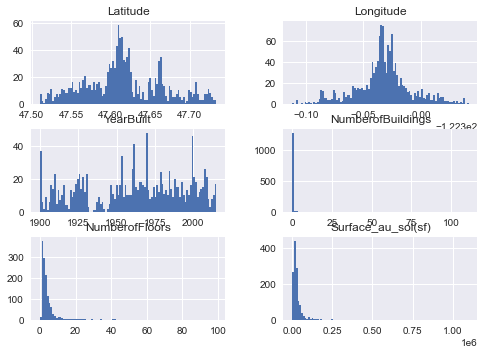

In [393]:
# Tracé des variables quantitatives avant recalibrage
plt.style.use('seaborn')
X_train_EUI[liste_variables_quantitatives].hist(bins=100)#, figsize=(22,15))
plt.show()

In [394]:
qt = QuantileTransformer(n_quantiles=1000, random_state=0, output_distribution='normal')
X_train_EUI_qt = qt.fit_transform(X_train_EUI[liste_variables_quantitatives])

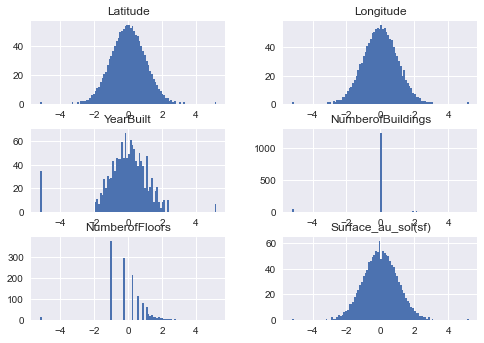

In [395]:
# Tracé des variables quantitatives après recalibrage
df_qt = pd.DataFrame(X_train_EUI_qt, columns=liste_variables_quantitatives)

plt.style.use('seaborn')
df_qt.hist(bins=100)
plt.show()

## Pipeline (imputation, one-hot encoding, recalibrage)

On combine les opérations décrites dans les chapitres précédents (imputation, one-hot encoding, recalibrage) en un workflow automatisé.

In [396]:
# On recrée les jeux de train/test avec split
X1 = df1[liste_variables_pour_modelisation].copy()
X_train_EUI, X_test_EUI, y_train_EUI, y_test_EUI = train_test_split(X1, y1_EUI, test_size=0.2, random_state=0)

### Pipeline variables quantitatives

In [397]:
pipeline_quanti = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('scaler', QuantileTransformer(n_quantiles=1000, random_state=0, output_distribution='normal')),
    ])

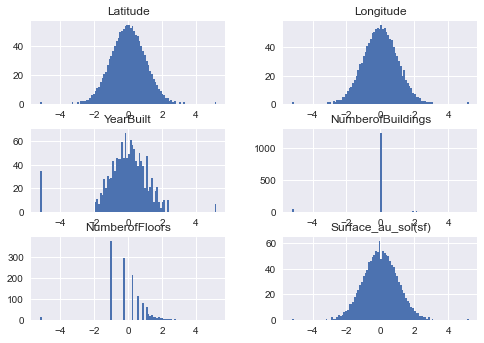

In [398]:
# test du pipeline
X_train_EUI_quanti = pipeline_quanti.fit_transform(X_train_EUI[liste_variables_quantitatives])

# Tracé des variables quantitatives après pipeline
df_quanti = pd.DataFrame(X_train_EUI_quanti, columns=liste_variables_quantitatives)
plt.style.use('seaborn')
df_quanti.hist(bins=100)
plt.show()

OK, on retrouve les mêmes histogrammes avec un pipeline.

### Pipeline variables qualitatives

L'imputer SimpleImputer de sklearn a un défaut de conception : lorsque le dataframe contient des données de type différents (string et numérique), les colonnes numériques sont imputées avec des strings.
Ce qui fait ensuiter bugger OneHotEncoder.
Il faut donc créer un imputeur maison et en faire un transformateur compatible avec un pipeline.

In [399]:
def Remplace_NA(df=None):
    """ Pour chaque variable, on remplace les valeurs null par une même valeur :  
      * 'ND' pour les strings,  
      * -1 pour les variables numériques.
    Args :
    - df : un dataframe.
    Returns : 
    - dff : le dataframe sans valeur null.
    """
    dff = df.copy()
    for var in liste_variables_qualitatives:
        if dff[var].dtype == 'object' :
            dff[var] = dff[var].fillna(value='ND', inplace=False)
        else :
            dff[var] = dff[var].fillna(value=-1, inplace=False)
    return dff
            
MonImputeur = FunctionTransformer(Remplace_NA)

In [400]:
pipeline_quali = Pipeline([
        ('imputer', MonImputeur),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

### Union des pipelines (ColumnTransformer)

In [401]:
full_pipeline = ColumnTransformer([
        ("quanti", pipeline_quanti, liste_variables_quantitatives),
        ("quali", pipeline_quali, liste_variables_qualitatives)
    ])

X_train_EUI_prepared = full_pipeline.fit_transform(X_train_EUI)
X_test_EUI_prepared = full_pipeline.transform(X_test_EUI)

X_train_EUI_prepared

<1320x241 sparse matrix of type '<class 'numpy.float64'>'
	with 18466 stored elements in Compressed Sparse Row format>

In [402]:
# visualisation du pipeline
# set_config(display='diagram')
full_pipeline

ColumnTransformer(transformers=[('quanti',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler',
                                                  QuantileTransformer(output_distribution='normal',
                                                                      random_state=0))]),
                                 ['Latitude', 'Longitude', 'YearBuilt',
                                  'NumberofBuildings', 'NumberofFloors',
                                  'Surface_au_sol(sf)']),
                                ('quali',
                                 Pipeline(steps=[('imputer',
                                                  FunctionTransformer(func=<function Remplace_NA at 0x00000000109EF550>)),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['BuildingType', 'PrimaryPropertyType',
                                  'ZipCode', 'CouncilDistrictCode',
                                  'Neighborhood', 'LargestPropertyUseType',
                                  'SecondLargestPropertyUseType',
                                  'ThirdLargestPropertyUseType'])])

## Régressions linéaires

### Régression linéaire simple

In [403]:
lin_reg = LinearRegression()

# Entrainement
lin_reg.fit(X_train_EUI_prepared, y_train_EUI)

LinearRegression()

In [404]:
some_data.shape

(100, 14)

In [405]:
some_data_prepared

<100x241 sparse matrix of type '<class 'numpy.float64'>'
	with 1399 stored elements in Compressed Sparse Row format>

In [406]:
X_train_EUI.shape

(1320, 14)

In [407]:
X_train_EUI_prepared

<1320x241 sparse matrix of type '<class 'numpy.float64'>'
	with 18466 stored elements in Compressed Sparse Row format>

In [408]:
# Test de quelques valeurs prédites
some_data = X_train_EUI.iloc[:100]
some_labels = y_train_EUI.iloc[:100].copy()
some_data_prepared = full_pipeline.transform(some_data)
some_data_predicted = lin_reg.predict(some_data_prepared)

some_labels['Prédictions'] = some_data_predicted
some_labels.head(10)

,SiteEUI(kBtu/sf),Prédictions
3162,42.799999,59.230377
953,37.599998,28.567644
2637,55.400002,74.624596
29,92.900002,75.240507
1126,36.799999,27.209902
773,45.500000,78.520747
305,89.300003,193.994349
2928,35.000000,75.721566
579,104.099998,92.325513
713,40.200001,21.662289


#### Metrics

##### RMSE :

In [409]:
EUI_predictions = lin_reg.predict(X_train_EUI_prepared)
lin_mse = mean_squared_error(y_train_EUI, EUI_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

44.14250276888454

##### MAE :

In [410]:
lin_mae = mean_absolute_error(y_train_EUI, EUI_predictions)
lin_mae

28.421632962349197

##### R² :

In [411]:
#R² par la méthode score() du transformateur
arrondi(lin_reg.score(X_train_EUI_prepared, y_train_EUI))

0.619

In [412]:
#R² par la fonction r2_score de metrics
arrondi(r2_score(y_train_EUI, EUI_predictions))

0.619

#### Scatter plot

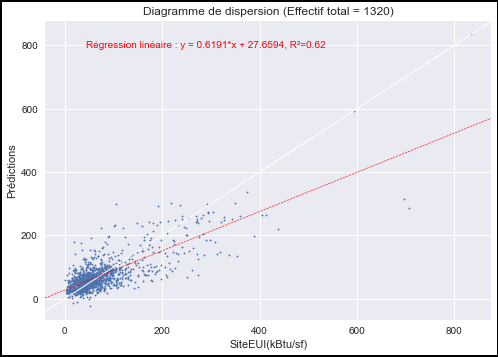

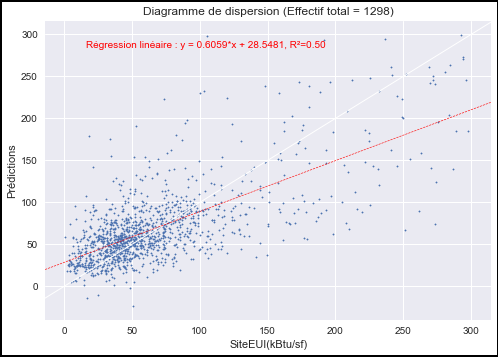

In [413]:
ser_predictions = pd.Series(np.squeeze(EUI_predictions), name='Prédictions')
scatter_plot(ser_x=y_train_EUI.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, ligne_diagonale=True)
scatter_plot(ser_x=y_train_EUI.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, max_x=300, max_y=300, ligne_diagonale=True)

#### Analyse des paramètres du modèle

In [414]:
lin_reg.intercept_

array([106.38667152])

In [415]:
print("lin_reg.coef_ shape :", lin_reg.coef_.shape)
coefs = lin_reg.coef_

lin_reg.coef_ shape : (1, 241)


In [416]:
modalites_var_quali = full_pipeline.named_transformers_['quali'].named_steps['encoder'].get_feature_names(input_features=liste_variables_qualitatives)
modalites_var_quali

array(['BuildingType_Campus', 'BuildingType_NonResidential', 'BuildingType_Nonresidential COS', 'BuildingType_SPS-District K-12',
       'PrimaryPropertyType_Distribution Center', 'PrimaryPropertyType_Hospital', 'PrimaryPropertyType_Hotel', 'PrimaryPropertyType_K-12 School',
       'PrimaryPropertyType_Laboratory', 'PrimaryPropertyType_Large Office', 'PrimaryPropertyType_Low-Rise Multifamily', 'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property', 'PrimaryPropertyType_Office', 'PrimaryPropertyType_Other', 'PrimaryPropertyType_Refrigerated Warehouse',
       'PrimaryPropertyType_Residence Hall', 'PrimaryPropertyType_Restaurant', 'PrimaryPropertyType_Retail Store', 'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Senior Care Community', 'PrimaryPropertyType_Small- and Mid-Sized Office', 'PrimaryPropertyType_Supermarket / Grocery Store',
       'PrimaryPropertyType_University', 'PrimaryPropertyType_Warehouse', 'PrimaryPropertyType_Wo

In [417]:
noms_des_coefs = np.concatenate([liste_variables_quantitatives, modalites_var_quali])

In [418]:
noms_des_coefs

array(['Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'Surface_au_sol(sf)', 'BuildingType_Campus', 'BuildingType_NonResidential',
       'BuildingType_Nonresidential COS', 'BuildingType_SPS-District K-12', 'PrimaryPropertyType_Distribution Center', 'PrimaryPropertyType_Hospital',
       'PrimaryPropertyType_Hotel', 'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Laboratory', 'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Low-Rise Multifamily', 'PrimaryPropertyType_Medical Office', 'PrimaryPropertyType_Mixed Use Property',
       'PrimaryPropertyType_Office', 'PrimaryPropertyType_Other', 'PrimaryPropertyType_Refrigerated Warehouse', 'PrimaryPropertyType_Residence Hall',
       'PrimaryPropertyType_Restaurant', 'PrimaryPropertyType_Retail Store', 'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Senior Care Community', 'PrimaryPropertyType_Small- and Mid-Sized Office', 'PrimaryPropertyType_Supermarket / Grocery

In [419]:
# inspiré de https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#interpreting-coefficients-scale-matters
df_coefs = pd.DataFrame(coefs.T, columns=['Coef'], index=noms_des_coefs)
with pd.option_context('display.max_rows', 300, 'display.max_colwidth', None, 'display.max_columns', 100, 'display.precision', 1) :
    display(df_coefs.sort_values(by='Coef', ascending=False))

,Coef
ZipCode_98013.0,393.9
ZipCode_98185.0,367.6
LargestPropertyUseType_Data Center,367.6
PrimaryPropertyType_Laboratory,184.2
PrimaryPropertyType_Supermarket / Grocery Store,154.2
LargestPropertyUseType_Restaurant,152.6
SecondLargestPropertyUseType_Data Center,131.2
LargestPropertyUseType_Other/Specialty Hospital,105.8
ThirdLargestPropertyUseType_Strip Mall,97.5
ThirdLargestPropertyUseType_Other - Recreation,95.9


In [420]:
df_coefs.loc[liste_variables_quantitatives]

,Coef
Latitude,5.504705
Longitude,6.462588
YearBuilt,-1.182663
NumberofBuildings,-1.682082
NumberofFloors,-0.685633
Surface_au_sol(sf),1.256171


#### Cross validation

In [421]:
lin_scores = cross_val_score(lin_reg, X_train_EUI_prepared, y_train_EUI,
                             scoring="neg_root_mean_squared_error", cv=10)
display_scores(-lin_scores)

Scores: 52.6 60.8 57.3 72.2 47.0 94.2 53.8 60.5 53.3 54.3 
Mean: 60.6
Standard deviation: 13.6


In [422]:
lin_scores = cross_val_score(lin_reg, X_train_EUI_prepared, y_train_EUI,
                             scoring="r2", cv=10)
display_scores(lin_scores)

Scores: 0.505 -0.195 0.0253 0.295 0.287 0.142 0.313 0.26 0.113 0.49 
Mean: 0.223
Standard deviation: 0.211


On passe de RMSE=44 (validation sur le jeu d'entraînement) à 61 (validation croisée) en moyenne.  
On passe de MAE=28 (validation sur le jeu d'entraînement) à 22 (validation croisée) en moyenne.  
On passe de R²=0.62 (validation sur le jeu d'entraînement) à 0.22 (validation croisée) en moyenne.  
La généralisation du modèle est très mauvaise (surajustement).

### Régression linéaire avec transformation de y_train

#### Transformation = QuantileTransformer

In [423]:
transformer = QuantileTransformer(output_distribution='normal')
regressor = LinearRegression()
regr_ttr = TransformedTargetRegressor(regressor=regressor, transformer=transformer)

# Entrainement
regr_ttr.fit(X_train_EUI_prepared, y_train_EUI)

TransformedTargetRegressor(regressor=LinearRegression(),
                           transformer=QuantileTransformer(output_distribution='normal'))

In [424]:
# Test de quelques valeurs prédites
some_data_predicted_ttr = regr_ttr.predict(some_data_prepared)

some_labels['Prédictions_ttr'] = some_data_predicted_ttr
some_labels.head(20)

,SiteEUI(kBtu/sf),Prédictions,Prédictions_ttr
3162,42.799999,59.230377,53.377343
953,37.599998,28.567644,32.000000
2637,55.400002,74.624596,73.542116
29,92.900002,75.240507,70.252179
1126,36.799999,27.209902,37.327752
773,45.500000,78.520747,56.000000
305,89.300003,193.994349,172.881348
2928,35.000000,75.721566,46.405772
579,104.099998,92.325513,85.926674
713,40.200001,21.662289,32.428055


##### RMSE :

In [425]:
EUI_predictions = regr_ttr.predict(X_train_EUI_prepared)
lin_mse = mean_squared_error(y_train_EUI, EUI_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

46.28090815019097

##### R²

In [426]:
#R² par la méthode score() du transformateur
regr_ttr.score(X_train_EUI_prepared, y_train_EUI)

0.5812790800110295

In [427]:
#R² par la fonction r2_score de metrics
r2_score(y_train_EUI, EUI_predictions)

0.5812790800110295

##### Scatter plot :

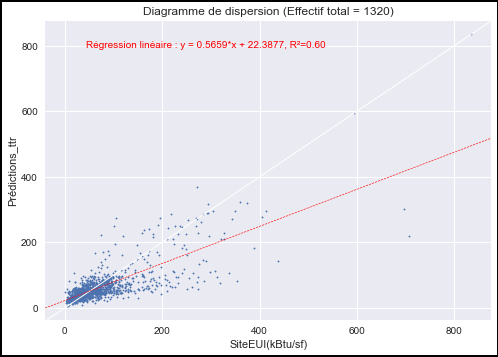

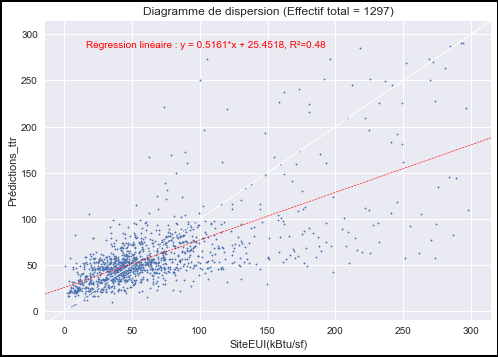

In [428]:
ser_predictions = pd.Series(np.squeeze(EUI_predictions), name='Prédictions_ttr')
scatter_plot(ser_x=y_train_EUI.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, ligne_diagonale=True)
scatter_plot(ser_x=y_train_EUI.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, max_x=300, max_y=300, ligne_diagonale=True)

Il n'y a pas eu d'amélioration par l'ajout d'une transformation de y_train.

#### Transformation = fonction log

In [429]:
regressor = LinearRegression()
regr_ttr2 = TransformedTargetRegressor(regressor=regressor, func=np.log, inverse_func=np.exp)

# Entrainement
regr_ttr2.fit(X_train_EUI_prepared, y_train_EUI)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())

In [430]:
# Test de quelques valeurs prédites
some_data_predicted_ttr = regr_ttr2.predict(some_data_prepared)

some_labels['Prédictions_ttr2'] = some_data_predicted_ttr
some_labels.head(20)

,SiteEUI(kBtu/sf),Prédictions,Prédictions_ttr,Prédictions_ttr2
3162,42.799999,59.230377,53.377343,56.714187
953,37.599998,28.567644,32.000000,31.113047
2637,55.400002,74.624596,73.542116,78.030090
29,92.900002,75.240507,70.252179,70.563247
1126,36.799999,27.209902,37.327752,35.053509
773,45.500000,78.520747,56.000000,56.132265
305,89.300003,193.994349,172.881348,151.302783
2928,35.000000,75.721566,46.405772,49.095230
579,104.099998,92.325513,85.926674,87.038591
713,40.200001,21.662289,32.428055,30.479381


##### RMSE :

In [431]:
EUI_predictions = regr_ttr2.predict(X_train_EUI_prepared)
lin_mse = mean_squared_error(y_train_EUI, EUI_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

45.66865325114479

##### R²

In [432]:
#R² par la méthode score() du transformateur
regr_ttr2.score(X_train_EUI_prepared, y_train_EUI)

0.5922844043372848

In [433]:
#R² par la fonction r2_score de metrics
r2_score(y_train_EUI, EUI_predictions)

0.5922844043372848

##### Scatter plot :

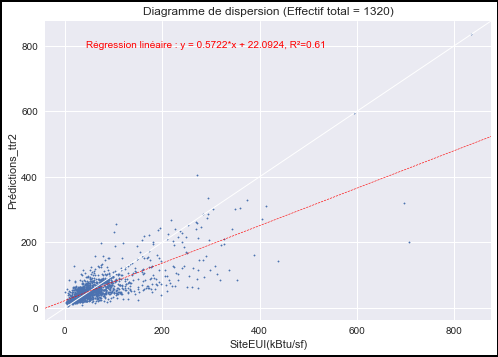

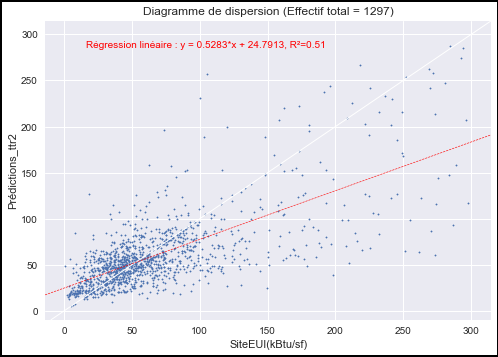

In [434]:
ser_predictions = pd.Series(np.squeeze(EUI_predictions), name='Prédictions_ttr2')
scatter_plot(ser_x=y_train_EUI.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, ligne_diagonale=True)
scatter_plot(ser_x=y_train_EUI.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, max_x=300, max_y=300, ligne_diagonale=True)

Il n'y a pas eu d'amélioration par l'ajout d'une transformation de y_train.

## Arbres de décision

##### Validation sur le jeu d'entrainement

In [435]:
tree_reg = DecisionTreeRegressor(random_state=0)
tree_reg.fit(X_train_EUI_prepared, y_train_EUI)

DecisionTreeRegressor(random_state=0)

In [436]:
EUI_predictions = tree_reg.predict(X_train_EUI_prepared)
tree_mse = mean_squared_error(y_train_EUI, EUI_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse  

0.0

In [437]:
print("R² =", r2_score(y_train_EUI, EUI_predictions))

R² = 1.0


RMSE = 0 et R² = 1 car car test sur jeu d'entrainement d'un arbre totalement ajusté

In [438]:
tree_reg.max_features_

241

In [439]:
tree_reg.n_features_

241

In [440]:
df_feature_importances = pd.Series(tree_reg.feature_importances_, index=noms_des_coefs)
df_feature_importances.sort_values(ascending=False).head(20)

PrimaryPropertyType_Supermarket / Grocery Store    0.141101
ZipCode_98185.0                                    0.086985
Surface_au_sol(sf)                                 0.078277
YearBuilt                                          0.075275
PrimaryPropertyType_Laboratory                     0.072730
Longitude                                          0.052652
LargestPropertyUseType_Parking                     0.044472
ZipCode_98013.0                                    0.041245
NumberofFloors                                     0.039012
Latitude                                           0.035285
PrimaryPropertyType_Other                          0.028502
SecondLargestPropertyUseType_Data Center           0.022783
LargestPropertyUseType_Restaurant                  0.021634
CouncilDistrictCode_3                              0.016896
PrimaryPropertyType_Warehouse                      0.016420
SecondLargestPropertyUseType_Laboratory            0.012207
PrimaryPropertyType_Hospital            

##### RMSE / validation croisée

In [441]:
scores = cross_val_score(tree_reg, X_train_EUI_prepared, y_train_EUI, 
                         scoring="neg_root_mean_squared_error", cv=10)
display_scores(-scores)

Scores: 64.1 84.4 69.2 84.7 52.0 107 77.5 76.6 51.9 66.0 
Mean: 73.3
Standard deviation: 16.6


##### R² / validation croisée

In [442]:
scores = cross_val_score(tree_reg, X_train_EUI_prepared, y_train_EUI, 
                         scoring="r2", cv=10)
display_scores(scores)

Scores: 0.265 -1.3 -0.42 0.0296 0.128 -0.105 -0.423 -0.186 0.16 0.247 
Mean: -0.161
Standard deviation: 0.474


On passe de RMSE=0 (validation sur le jeu d'entraînement) à 74 (validation croisée) en moyenne.  
On passe de R²=1 (validation sur le jeu d'entraînement) à -0.16 (validation croisée) en moyenne.  
La généralisation du modèle est très mauvaise (surajustement).

##### Dessin de l'arbre

In [443]:
export_graphviz(
        tree_reg,
        out_file="tree_reg.dot",
        feature_names=noms_des_coefs,
        class_names="SiteEUI(kBtu/sf)",
        rounded=True,
        filled=True
    )

In [488]:
# Source.from_file("tree_reg.dot")   # l'affichage du graphe augmente la taille du fichier .ipynb de 3 Mo

In [445]:
tree_reg.get_n_leaves()

1314

In [446]:
tree_reg.get_depth()

62

### Régularisation

In [447]:
param_grid = [{'max_depth': [2, 4, 8, 16, 32, 64], 'random_state': [0]}, {'min_samples_leaf': [2**x for x in range(11)], 'random_state': [0]}]
grid_search = GridSearchCV(tree_reg, param_grid, cv=10,
                           scoring='r2', return_train_score=True)
grid_search.fit(X_train_EUI_prepared, y_train_EUI.iloc[:,0])

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=0),
             param_grid=[{'max_depth': [2, 4, 8, 16, 32, 64],
                          'random_state': [0]},
                         {'min_samples_leaf': [1, 2, 4, 8, 16, 32, 64, 128, 256,
                                               512, 1024],
                          'random_state': [0]}],
             return_train_score=True, scoring='r2')

In [448]:
grid_search.best_params_

{'max_depth': 4, 'random_state': 0}

In [449]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("R² =", arrondi(mean_score), params)

R² = 0.125 {'max_depth': 2, 'random_state': 0}
R² = 0.157 {'max_depth': 4, 'random_state': 0}
R² = 0.031 {'max_depth': 8, 'random_state': 0}
R² = -0.0101 {'max_depth': 16, 'random_state': 0}
R² = -0.117 {'max_depth': 32, 'random_state': 0}
R² = -0.111 {'max_depth': 64, 'random_state': 0}
R² = -0.161 {'min_samples_leaf': 1, 'random_state': 0}
R² = -0.0525 {'min_samples_leaf': 2, 'random_state': 0}
R² = 0.00766 {'min_samples_leaf': 4, 'random_state': 0}
R² = 0.103 {'min_samples_leaf': 8, 'random_state': 0}
R² = 0.149 {'min_samples_leaf': 16, 'random_state': 0}
R² = 0.117 {'min_samples_leaf': 32, 'random_state': 0}
R² = 0.0468 {'min_samples_leaf': 64, 'random_state': 0}
R² = 0.0585 {'min_samples_leaf': 128, 'random_state': 0}
R² = 0.00834 {'min_samples_leaf': 256, 'random_state': 0}
R² = -0.00319 {'min_samples_leaf': 512, 'random_state': 0}
R² = -0.00342 {'min_samples_leaf': 1024, 'random_state': 0}


Le meilleur R² est médiocre.

In [450]:
# Généralisation sur le test set
EUI_predictions = grid_search.predict(X_test_EUI_prepared)
print("R² =", r2_score(y_test_EUI, EUI_predictions))

R² = -0.05364330966345543


La généralisation échoue à faire mieux qu'un DummyRegressor.

## Forêts aléatoires

In [457]:
forest_reg = RandomForestRegressor(n_estimators=100, random_state=0)
forest_reg.fit(X_train_EUI_prepared, y_train_EUI.iloc[:,0])

RandomForestRegressor(random_state=0)

In [453]:
forest_scores = cross_val_score(forest_reg, X_train_EUI_prepared, y_train_EUI.iloc[:,0],
                                scoring="neg_root_mean_squared_error", cv=10)
display_scores(-forest_scores)

Scores: 47.4 56.9 50.3 66.7 42.7 92.8 57.1 61.6 44.7 54.2 
Mean: 57.5
Standard deviation: 14.5


In [454]:
forest_scores = cross_val_score(forest_reg, X_train_EUI_prepared, y_train_EUI.iloc[:,0],
                                scoring="r2", cv=10)
display_scores(forest_scores)

Scores: 0.598 -0.0489 0.249 0.397 0.41 0.167 0.227 0.232 0.375 0.492 
Mean: 0.31
Standard deviation: 0.184


C'est mauvais.

### Régularisation

##### GridSearchCV à une dimension :

In [493]:
param_grid = [{'max_depth': [2, 4, 8, 16, 32, 64]}, {'min_samples_leaf': [2**x for x in range(11)]}]
grid_search = GridSearchCV(forest_reg, param_grid, cv=10,
                           scoring='r2', return_train_score=True, n_jobs=-1)
grid_search.fit(X_train_EUI_prepared, y_train_EUI.iloc[:,0])

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid=[{'max_depth': [2, 4, 8, 16, 32, 64]},
                         {'min_samples_leaf': [1, 2, 4, 8, 16, 32, 64, 128, 256,
                                               512, 1024]}],
             return_train_score=True, scoring='r2')

In [490]:
grid_search.best_params_

{'min_samples_leaf': 4}

In [494]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("R² =", arrondi(mean_score), params)

R² = 0.17 {'max_depth': 2}
R² = 0.197 {'max_depth': 4}
R² = 0.249 {'max_depth': 8}
R² = 0.299 {'max_depth': 16}
R² = 0.314 {'max_depth': 32}
R² = 0.31 {'max_depth': 64}
R² = 0.31 {'min_samples_leaf': 1}
R² = 0.309 {'min_samples_leaf': 2}
R² = 0.316 {'min_samples_leaf': 4}
R² = 0.282 {'min_samples_leaf': 8}
R² = 0.249 {'min_samples_leaf': 16}
R² = 0.123 {'min_samples_leaf': 32}
R² = 0.0929 {'min_samples_leaf': 64}
R² = 0.0472 {'min_samples_leaf': 128}
R² = 0.0147 {'min_samples_leaf': 256}
R² = -0.00345 {'min_samples_leaf': 512}
R² = -0.00345 {'min_samples_leaf': 1024}


Pour les mêmes jeux de paramètres param_grid, RandomForestRegressor est plus performant que DecisionTreeRegressor.

##### GridSearchCV à deux dimensions :

In [478]:
param_grid = [{'max_depth': [16, 32, 64], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8]}]
grid_search = GridSearchCV(forest_reg, param_grid, cv=10,
                           scoring='r2', return_train_score=True, n_jobs=-1)
grid_search.fit(X_train_EUI_prepared, y_train_EUI.iloc[:,0])

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid=[{'max_depth': [16, 32, 64],
                          'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8],
                          'random_state': [0]}],
             return_train_score=True, scoring='r2')

In [479]:
grid_search.best_params_

{'max_depth': 32, 'min_samples_leaf': 4, 'random_state': 0}

In [480]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("R² =", str(arrondi(mean_score)).rjust(8, ' '), params)

R² = 0.299 {'max_depth': 16, 'min_samples_leaf': 1, 'random_state': 0}
R² = 0.304 {'max_depth': 16, 'min_samples_leaf': 2, 'random_state': 0}
R² = 0.313 {'max_depth': 16, 'min_samples_leaf': 3, 'random_state': 0}
R² = 0.315 {'max_depth': 16, 'min_samples_leaf': 4, 'random_state': 0}
R² = 0.31 {'max_depth': 16, 'min_samples_leaf': 5, 'random_state': 0}
R² = 0.307 {'max_depth': 16, 'min_samples_leaf': 6, 'random_state': 0}
R² = 0.294 {'max_depth': 16, 'min_samples_leaf': 7, 'random_state': 0}
R² = 0.282 {'max_depth': 16, 'min_samples_leaf': 8, 'random_state': 0}
R² = 0.314 {'max_depth': 32, 'min_samples_leaf': 1, 'random_state': 0}
R² = 0.309 {'max_depth': 32, 'min_samples_leaf': 2, 'random_state': 0}
R² = 0.315 {'max_depth': 32, 'min_samples_leaf': 3, 'random_state': 0}
R² = 0.316 {'max_depth': 32, 'min_samples_leaf': 4, 'random_state': 0}
R² = 0.312 {'max_depth': 32, 'min_samples_leaf': 5, 'random_state': 0}
R² = 0.31 {'max_depth': 32, 'min_samples_leaf': 6, 'random_state': 0}
R² = 0.2

##### Généralisation sur le test set

In [481]:
EUI_predictions = grid_search.predict(X_test_EUI_prepared)
print("R² =", arrondi(r2_score(y_test_EUI, EUI_predictions)))

R² = 0.3096345583705329


La généralisation est médiocre.

In [482]:
df_feature_importances = pd.Series(forest_reg.feature_importances_, index=noms_des_coefs)
df_feature_importances.sort_values(ascending=False).head(20)

PrimaryPropertyType_Supermarket / Grocery Store               0.092250
Surface_au_sol(sf)                                            0.064397
PrimaryPropertyType_Laboratory                                0.062662
LargestPropertyUseType_Supermarket/Grocery Store              0.057916
YearBuilt                                                     0.057820
Longitude                                                     0.048198
LargestPropertyUseType_Data Center                            0.048040
Latitude                                                      0.039125
ZipCode_98185.0                                               0.034888
SecondLargestPropertyUseType_Data Center                      0.030591
NumberofFloors                                                0.030379
PrimaryPropertyType_Other                                     0.025622
ZipCode_98013.0                                               0.025199
LargestPropertyUseType_Restaurant                             0.020756
Larges

## SVM Regressor

In [455]:
svm_reg = SVR(kernel="linear")
svm_reg.fit(X_train_EUI_prepared, y_train_EUI.iloc[:,0])

SVR(kernel='linear')

In [456]:
SVR_predictions = svm_reg.predict(X_train_EUI_prepared)
svm_mse = mean_squared_error(y_train_EUI, SVR_predictions)
svm_rmse = np.sqrt(svm_mse)
print("RMSE = ", svm_rmse)

RMSE =  64.67004836227653


C'est mauvais.